# Quantum Machine Learning

In [7]:
# Importing packages 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import qiskit
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.circuit import QuantumCircuit
from qiskit.algorithms.optimizers import SPSA

We find the parity of randomly choosen column by adding the index after converting it into its binary form and apply modulo 2 operation. In order to get the parity in the Z basis we do the calculation of 1 - 2*( parity we got).

In [8]:
# Defining labels_actual or actual parity.
def parity(index):
    bits = bin(index)  # Coverting into binary.
    tot = sum([int(b) for b in bits[2:]]) # Eg: 0b101, hence we remove first two bits.
    res = tot%2
    res=1-2*res # Gives parity in Z basis.
    return(res)

In [9]:
# Parity check on test data or unseen samples.
parity_operator =np.array([[1,0,0,0],[0,-1,0,0], [0,0,-1,0],[0,0,0,1]]) # Z⊗Z , another way of measuring parity

def parity_check(vector):
    return vector.transpose().conjugate() @ parity_operator @ vector
    

We define a function 'training_data ' which returns 'result' and 'labels' where 'results' is an empty array where randomly choosen column from the identity matrix get appended and 'label' array get appended from the 'parity' function.

In [10]:
# Defining training data by randomly choosing columbs of identity matrix
def training_data(num):
    global n
    n = 2 
    dimension = 2**n
    identity_matrix = np.identity(dimension, dtype = int)

    result =[]
    labels =[]
    for i in range(num):
        index = np.random.randint(0,dimension)
        result.append (identity_matrix[:,index])
        labels.append (parity(index))
    return result,labels 

We construct the ansatz circuit. $R_{ZX}$ gate is performed on qubits 0 and 1 while $R_Z$ on qubit 0 and and $R_X$ gate on qubit 1. Finally, the last qubit is measured and a classical bit is stored as output. The '0' on the classical bit denotes the measurement number.

#### 

In [11]:
# Constructing the circuit and calls training_data as input and assign parameters for each theta.
def ansatz_2(inp,parameters):
    global n
    c_reg = 1
    global qc
    qc = qiskit.QuantumCircuit(n,c_reg)
    qc.initialize(inp)
    qc.rx(parameters[0],  1)
    qc.rz(parameters[1],  0)
    qc.rzx(parameters[2], 0, 1)
    qc.measure(1,0)
    return(qc)

In [12]:
# Constructing the same ansatz for checking the test data.
def ansatz_2_check(parameters,vector):
    global n
    c_reg = 1
    global qc
    qc = qiskit.QuantumCircuit(n,c_reg)
    qc.initialize(vector)
    qc.rx(parameters[0],  1)
    qc.rz(parameters[1],  0)
    qc.rzx(parameters[2], 0, 1)
    qc.measure(1,0)
    return(qc)

We simulates the circuit using 'Aer simulator' and get the counts of 0 and 1 and find the expectation value to get the measured parity. We then define the cost function for optimisation.

In [13]:
# Simulating the circuit to get counts.
def entropy(inp,par,parameters): # (inp = input,par = parity,parameters)
    shots= 1024
    circuit=ansatz_2(inp,parameters)
    qc.draw('mpl') # To display the circuit.
    sim = qiskit.Aer.get_backend('aer_simulator_statevector')  
    counts = (sim.run(circuit.compose(circuit),shots = shots).result().get_counts()) 

# For loop incase we get counts for both 0 and 1.    
    probs={}
    for output in ['0','1']:
        if output in counts:
            probs[output] = counts[output]
        else:
            probs[output] = 0
    counts_0 = probs['0']
    counts_1 = probs['1']
    
# Calculating expectation value of counts.
    labels_measured = 1/shots* (counts_0 * 1 + counts_1 * -1)
    labels_actual = par
    
# Quadratic cost function.
    quadratic_error = (labels_actual - labels_measured)**2
    return(quadratic_error)

We take the sum of cost function of 50 samples and divide it by the total number of sample.

In [14]:
def cost_function(parameters):
    p_cost=0
    global k
    z = 50 # Taking 50 samples.
    for a in range(z):
        p_cost+=entropy(k[0][a],k[1][a],parameters) 
    p_cost=p_cost/z
    return p_cost

In [28]:
# Cost function to check unseen examples.
def cost_function_check(parameters,vector):
    shots= 1024
    circuit=ansatz_2_check(parameters,vector)
    sim = qiskit.Aer.get_backend('aer_simulator_statevector')
    counts = (sim.run(circuit.compose(circuit),shots = shots).result().get_counts())
    #plot_histogram(counts, title=' counts')
    #print(counts)
    probs={}
    for output in ['0','1']:
        if output in counts:
            probs[output] = counts[output]
        else:
            probs[output] = 0     
    counts_0 = probs['0']
    counts_1 = probs['1']   
    
    labels_measured = 1/shots* (counts_0*1 + counts_1*-1)
    print("labels_measured =", labels_measured)
    labels_actual = parity_check(vector)
    print("labels_actual = ", labels_actual)
    
    quadratic_error = (labels_actual - labels_measured)**2
    return(quadratic_error)

In [16]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
log = OptimizerLog()
global k
k = training_data(50)
initial = np.random.rand(3)

Powell method from SciPy is used to optimise the cost function and to generate optimal parameters.

In [21]:
result_powell = minimize(cost_function,initial,method = 'powell')
print(result_powell)

for k0 in range(5):
    print(cost_function(result_powell.x))
    


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 7.62939453125e-08
       x: [ 4.722e+00  9.746e-01  1.567e+00]
     nit: 3
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00]]
    nfev: 137
7.62939453125e-08
0.0
7.62939453125e-08
1.52587890625e-07
7.62939453125e-08


SPSA method from qiskit is used to optimise the cost function and to generate optimal parameters.

In [18]:
optimizer = SPSA(maxiter=100,callback=log.update)
result_spsa = optimizer.minimize(cost_function,initial )
print(result_spsa)

# Cost function for 5 random training data.
for k0 in range(5):
    print(cost_function(result_spsa.x)) 

{   'fun': 0.000908050537109375,
    'jac': None,
    'nfev': 300,
    'nit': None,
    'njev': None,
    'x': array([ 1.53835059, -0.49422772, -1.33167846])}
0.000998077392578125
0.000927734375
0.0009745025634765625
0.000917205810546875
0.0008331298828125


Plotting graph to show how the cost function converges after each function evaluation with SPSA method.

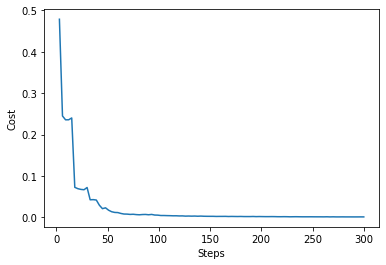

In [19]:
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()


Checking parity of unseen examples with both Powell and SPSA Method.

In [31]:
vector = np.array([1,1j,-1j,0])
# Powell Method.
print("Error =" ,cost_function_check(result_powell.x, vector/np.linalg.norm(vector)))

labels_measured = -0.359375
labels_actual =  (-0.3333333333333334+0j)
Error = (0.000678168402777773+0j)


In [32]:
# SPSA method.
print("Error =" ,cost_function_check(result_spsa.x, vector/np.linalg.norm(vector)))

labels_measured = -0.474609375
labels_actual =  (-0.3333333333333334+0j)
Error = (0.01995891994900171+0j)
